# Subpocket center robustness

We aim for robust subpocket centers, in order to calculate comparable subpocket distances across kinase structures.

- Mean/standard deviation for centers between and across subpockets
- Superimpose structures with their subpocket centers
  - Random
  - DFG-in vs. DFG-out (see “Find conformations!”)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from opencadd.databases.klifs import setup_remote
from opencadd.structure.pocket import PocketKlifs, PocketViewer

from kissim.definitions import ANCHOR_RESIDUES
from kissim.encoding import FingerprintGenerator

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "../../data/"
RESULTS = HERE / "../../results/"

In [5]:
REMOTE = setup_remote()

## Load fingerprints

Let's load our pre-calculated fingerprint saved in a _json_ file as `FingerprintGenerator` object.

In [6]:
fingerprint_generator = FingerprintGenerator.from_json(
    RESULTS / "fingerprints_clean.json", normalize=True
)
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4916


## Load KLIFS reference PDB IDs

Load KLIFS reference structures and add structure KLIFS IDs.

In [7]:
# Get KLIFS reference structures
klifs_reference_structures = pd.read_csv(
    DATA / "external" / "klifs_reference_structures.csv", delimiter=";"
)
klifs_reference_structures["structure.pdb_id"] = klifs_reference_structures[
    "structure.pdb_id"
].apply(lambda x: x.lower())
# Get metadata for these reference structures from KLIFS remote
structures = REMOTE.structures.by_structure_pdb_id(
    klifs_reference_structures["structure.pdb_id"].to_list()
)
structures = structures[
    ["structure.klifs_id", "structure.pdb_id", "structure.chain", "structure.alternate_model"]
]
# Merge information
klifs_reference_structures = klifs_reference_structures.merge(
    structures, how="left", on=["structure.pdb_id", "structure.chain", "structure.alternate_model"]
)
klifs_reference_structures

,kinase.group,kinase.klifs_name,structure.pdb_id,structure.chain,structure.alternate_model,ligand.name,structure.klifs_id
0,AGC,ROCK1,3d9v,A,-,H-1152P,2696
1,AGC,AKT2,3d0e,A,-,GSK690693,1912
2,AGC,PDK1,1uu3,A,A,LY333531,3180
3,CAMK,LCK,1qpd,A,-,Staurosporine,2267
4,CAMK,PHKg2,2y7j,A,A,Sunitinib,1894
5,CAMK,DAPK1,1wvx,A,-,BDB402,5616
6,CK1,CK1g3,2izs,A,A,4-amino-2-((3-chlorophenyl)amino)-5-(4-fluorob...,2228
7,CK1,CK1g1,2cmw,A,A,2-(2-hydroxyethylamino)-6-(3-chloroanilino)-9-...,5567
8,CK1,CK1g3,2chl,A,A,"5-amino-N-(2,6-difluorophenyl)-3-((4-sulfamoyl...",2220
9,CMGC,GSK3B,3zrm,A,A,"7-(4-hydroxyphenyl)-2-(pyridin-4-yl)thieno[3,2...",751


Remove reference structures that are not part of our dataset.

In [8]:
klifs_reference_structures = klifs_reference_structures[
    klifs_reference_structures["structure.klifs_id"].isin(list(fingerprint_generator.data.keys()))
].reset_index()
klifs_reference_structures

,index,kinase.group,kinase.klifs_name,structure.pdb_id,structure.chain,structure.alternate_model,ligand.name,structure.klifs_id
0,1,AGC,AKT2,3d0e,A,-,GSK690693,1912
1,3,CAMK,LCK,1qpd,A,-,Staurosporine,2267
2,5,CAMK,DAPK1,1wvx,A,-,BDB402,5616
3,6,CK1,CK1g3,2izs,A,A,4-amino-2-((3-chlorophenyl)amino)-5-(4-fluorob...,2228
4,7,CK1,CK1g1,2cmw,A,A,2-(2-hydroxyethylamino)-6-(3-chloroanilino)-9-...,5567
5,8,CK1,CK1g3,2chl,A,A,"5-amino-N-(2,6-difluorophenyl)-3-((4-sulfamoyl...",2220
6,12,Other,TTK,3gfw,A,-,Mps1-IN-1,4714
7,13,Other,AurA,2xru,A,-,PHA-828300,1954
8,14,Other,Wee1,1x8b,A,-,PD0407824,209
9,15,STE,MST3,3a7i,A,-,Adenine,5611


## Inter-subpocket distances within each structure

In [9]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_names = subpocket_centers.columns.get_level_values("subpocket").unique()
subpocket_pairs = itertools.combinations(subpocket_names, 2)
distances = {}
for subpocket_pair in subpocket_pairs:
    difference = subpocket_centers[subpocket_pair[0]] - subpocket_centers[subpocket_pair[1]]
    distance = difference.dropna().apply(lambda x: np.linalg.norm(x), axis=1)
    distances[subpocket_pair] = distance
distances = pd.DataFrame(distances)
distances

hinge_region                          dfg_region           front_pocket
        dfg_region front_pocket    center front_pocket    center       center
1         9.469565     6.086583  4.729283     9.883736  7.327429     5.321845
2         9.464422     6.407095  5.014029    10.062895  7.090676     5.594592
8        10.248727     6.489513  5.109358    10.715704  7.581782     5.576537
11       10.732556     6.367466  5.210495    11.136788  7.647271     5.563454
15       11.174454     6.477832  5.237044    12.601992  8.087461     6.247401
...            ...          ...       ...          ...       ...          ...
13029    10.459132     6.415950  5.563868    11.414586  7.343659     5.925618
13034    10.287338     6.476519  5.304604    10.864191  7.967823     5.242968
13035    10.376052     6.433025  5.506401    11.380352  7.349428     5.903395
13037     9.374709     6.932446  5.603139     9.213518  6.616313     5.213832
13039     9.680273     7.096647  5.773842     9.444947  6.678425     5.359182

[4914 rows x 6 columns]

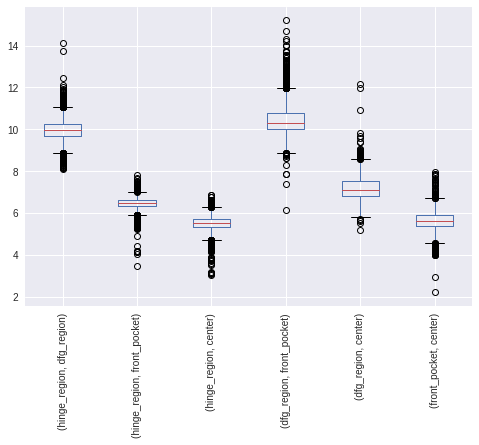

In [10]:
distances.plot(kind="box", rot=90);

In [11]:
distances_stats = pd.concat([distances.std(), distances.mean()], axis=1)
distances_stats.columns = ["std", "mean"]
distances_stats

std       mean
hinge_region dfg_region    0.571454  10.025556
             front_pocket  0.317113   6.431957
             center        0.346237   5.494069
dfg_region   front_pocket  0.836184  10.545455
             center        0.506446   7.179750
front_pocket center        0.478463   5.630862

In [12]:
distances_stats = distances_stats.reset_index()

distances_stats_1 = distances_stats.copy()
distances_stats_1 = distances_stats_1.rename(
    columns={"level_0": "subpocket 1", "level_1": "subpocket 2"}
)
distances_stats_2 = distances_stats.copy()
distances_stats_2 = distances_stats_2.rename(
    columns={"level_1": "subpocket 1", "level_0": "subpocket 2"}
)

distances_stats = pd.concat([distances_stats_1, distances_stats_2])
distances_stats

,subpocket 1,subpocket 2,std,mean
0,hinge_region,dfg_region,0.571454,10.025556
1,hinge_region,front_pocket,0.317113,6.431957
2,hinge_region,center,0.346237,5.494069
3,dfg_region,front_pocket,0.836184,10.545455
4,dfg_region,center,0.506446,7.179750
5,front_pocket,center,0.478463,5.630862
0,dfg_region,hinge_region,0.571454,10.025556
1,front_pocket,hinge_region,0.317113,6.431957
2,center,hinge_region,0.346237,5.494069
3,front_pocket,dfg_region,0.836184,10.545455


## Intra-subpocket distances to reference structure

In [13]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_names = subpocket_centers.columns.get_level_values("subpocket").unique()
structure_klifs_ids = klifs_reference_structures["structure.klifs_id"].to_list()

distances = {}

for subpocket_name in subpocket_names:
    distances[subpocket_name] = {}
    for structure_klifs_id in structure_klifs_ids:
        difference = (
            subpocket_centers[subpocket_name].drop(structure_klifs_id)
            - subpocket_centers[subpocket_name].loc[structure_klifs_id, :]
        )
        distance = difference.dropna().apply(lambda x: np.linalg.norm(x), axis=1)
        distances[subpocket_name][structure_klifs_id] = distance
    distances[subpocket_name] = pd.DataFrame(distances[subpocket_name])

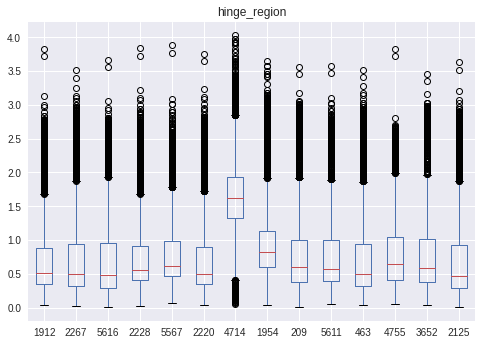

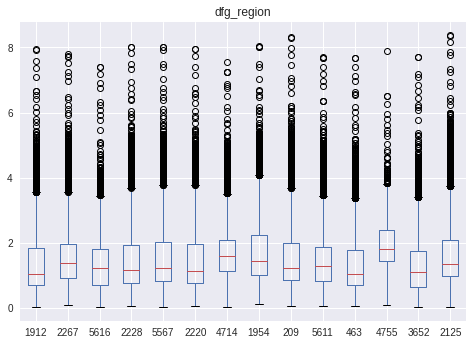

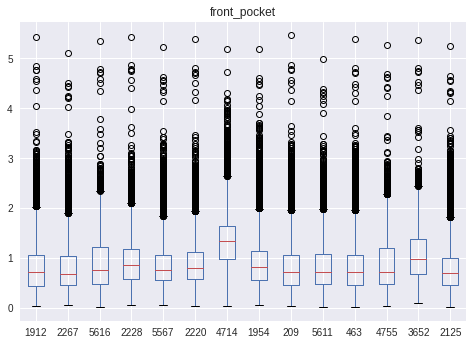

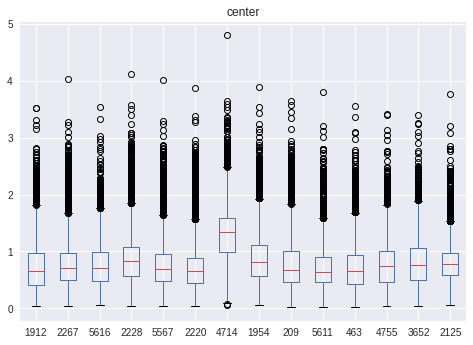

In [14]:
for subpocket_name in subpocket_names:
    distances[subpocket_name].plot(kind="box", title=subpocket_name)

In [15]:
# Get mean of each reference structure's std
distances_stats_intra = []
for subpocket_name in subpocket_names:
    distance_std = distances[subpocket_name].std().mean()
    distance_mean = distances[subpocket_name].mean().mean()
    distances_stats_intra.append([subpocket_name, subpocket_name, distance_std, distance_mean])
distances_stats_intra = pd.DataFrame(
    distances_stats_intra, columns=["subpocket 1", "subpocket 2", "std", "mean"]
)

## Heatmap for inter- and intra-subpocket distances (mean/std)

In [16]:
distances_stats = pd.concat([distances_stats, distances_stats_intra]).reset_index(drop=True)
distances_stats

,subpocket 1,subpocket 2,std,mean
0,hinge_region,dfg_region,0.571454,10.025556
1,hinge_region,front_pocket,0.317113,6.431957
2,hinge_region,center,0.346237,5.494069
3,dfg_region,front_pocket,0.836184,10.545455
4,dfg_region,center,0.506446,7.179750
5,front_pocket,center,0.478463,5.630862
6,dfg_region,hinge_region,0.571454,10.025556
7,front_pocket,hinge_region,0.317113,6.431957
8,center,hinge_region,0.346237,5.494069
9,front_pocket,dfg_region,0.836184,10.545455


In [17]:
distances_std_pivot = distances_stats.drop("mean", axis=1).pivot(
    columns="subpocket 1", index="subpocket 2", values="std"
)
distances_std_pivot

subpocket 1,center,dfg_region,front_pocket,hinge_region
subpocket 2,,,,
center,0.435514,0.506446,0.478463,0.346237
dfg_region,0.506446,0.995670,0.836184,0.571454
front_pocket,0.478463,0.836184,0.590301,0.317113
hinge_region,0.346237,0.571454,0.317113,0.595111


In [18]:
distances_mean_pivot = distances_stats.drop("std", axis=1).pivot(
    columns="subpocket 1", index="subpocket 2", values="mean"
)
# Reverse column names to that they overlay with the heatmap
reversed_column_names = distances_mean_pivot.columns.to_list()[::-1]
distances_mean_pivot = distances_mean_pivot.loc[reversed_column_names, reversed_column_names]
distances_mean_pivot

subpocket 1,hinge_region,front_pocket,dfg_region,center
subpocket 2,,,,
hinge_region,0.844505,6.431957,10.025556,5.494069
front_pocket,6.431957,0.950497,10.545455,5.630862
dfg_region,10.025556,10.545455,1.556575,7.179750
center,5.494069,5.630862,7.179750,0.825266


Text(51.0, 0.5, '')

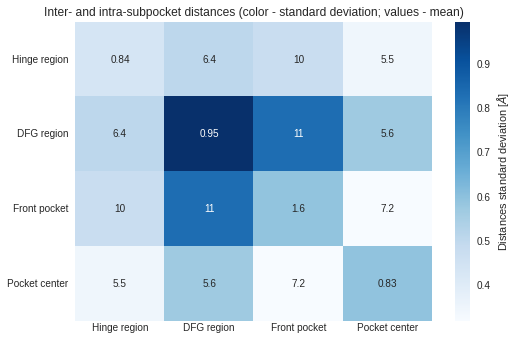

In [19]:
sns.heatmap(
    distances_std_pivot,
    cmap="Blues",
    annot=distances_mean_pivot,
    cbar_kws={"label": "Distances standard deviation [$\AA$]"},
)
labels = ["Hinge region", "DFG region", "Front pocket", "Pocket center"]
plt.title("Inter- and intra-subpocket distances (color - standard deviation; values - mean)")
plt.xticks(np.arange(4) + 0.5, (labels), rotation=0, va="center")
plt.yticks(np.arange(4) + 0.5, (labels), rotation=0, va="center")
plt.xlabel("")
plt.ylabel("")
# sns.set(font_scale=2)

Key takeaways:

- Distance mean
  - Pocket center, hinge region, and front pocket are about equally spaced from each other (~6A)
  - DFG region is a bit further away (closer to pocket center than to hinge region and front pocket)
- Distance standard deviation
  - Standard deviations are all below 1A
  - DFG subpocket shows most variation (w.r.t. DFG conformations), followed by the front pocket (w.r.t. flexible p-loop)


## Show example structure with subpockets

Let's show an example structure with subpockets to make sense of the mean distances that we have calculated.

In [20]:
subpockets = {
    "anchor_residue.klifs_ids": list(ANCHOR_RESIDUES.values()),
    "subpocket.name": list(ANCHOR_RESIDUES.keys()),
    "subpocket.color": ["magenta", "cyan", "green"],
}
subpockets

{'anchor_residue.klifs_ids': [[16, 47, 80], [19, 24, 81], [10, 48, 72]],
 'subpocket.name': ['hinge_region', 'dfg_region', 'front_pocket'],
 'subpocket.color': ['magenta', 'cyan', 'green']}

In [21]:
pocket = PocketKlifs.from_structure_klifs_id(3652, subpockets)

In [22]:
subpocket_coords = (
    pocket.subpockets[["subpocket.name", "subpocket.center"]].set_index("subpocket.name").squeeze()
)
subpocket_coords = pd.concat(
    [subpocket_coords, pd.Series([pocket.center.tolist()], index=["center"])]
)

distances_example_structure = {}
subpocket_pairs = itertools.combinations(subpocket_coords.index, 2)
for subpocket_pair in subpocket_pairs:
    difference = subpocket_coords[subpocket_pair[0]] - subpocket_coords[subpocket_pair[1]]
    distance = np.linalg.norm(difference)
    distances_example_structure[subpocket_pair] = distance
distances_example_structure

{('hinge_region', 'dfg_region'): 9.955494,
 ('hinge_region', 'front_pocket'): 6.3870726,
 ('hinge_region', 'center'): 5.538795222621422,
 ('dfg_region', 'front_pocket'): 10.053213,
 ('dfg_region', 'center'): 7.183169918155383,
 ('front_pocket', 'center'): 5.249160890296896}

In [23]:
viewer = PocketViewer()
viewer.add_pocket(pocket)
viewer.viewer

NGLWidget()

In [24]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

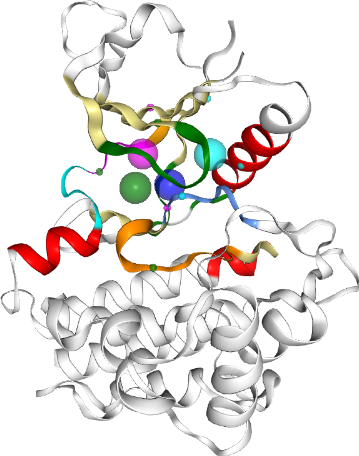

In [25]:
viewer.viewer._display_image()